<div class="anchor" style="color:rosybrown" > 
    <h1 style="font-size:200%; text-align:center">Modelo de Previsão Usando o Algorítmo de LightGBM</h1> 
    <p>Abaixo, você encontrará o modelo de machine learning que desenvolvi para prever a produção de vestuário. Este modelo é o resultado de uma análise aprofundada dos dados, realizada no meu notebook de Exploratory Data Analysis (Análise Exploratória de Dados). No notebook, você encontrará informações detalhadas sobre o conjunto de dados utilizado e seu funcionamento. Para facilitar a navegação e compreensão, dividi o notebook em tópicos, com um sumário disponível logo abaixo. Em cada etapa do processo, você encontrará explicações detalhadas sobre as metodologias e técnicas que empreguei.</p>
    <h2 style="font-size:200%; text-align:center">Sumário</h2>  
    <ul>
        <li><a href="#imports">Bibliotecas</a></li>
        <li><a href="#tratamento">Importação e Tratamento de Dados</a></li>
        <li><a href="#0">Modelo Previsor Exploratória de Dados</a></li>
            <ul>
                <li><a href="#0.1">Função Feature Engineering</a></li>
                <li><a href="#0.2">Função das Métricas de Avaliação</a></li>
                <li><a href="#0.3">Função do Modelo Previsor</a></li>
            </ul>
        <li><a href="#1">Resultados</a></li>  
    </ul>
    
</div>


<div id='imports'>
    <h1 id='imports'style="color:rosybrown ;text-align:center">Bibliotecas</h1>
</div>    

In [1]:
# Standards Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mahcine learning libraries
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

# Ignorar todos os avisos
warnings.filterwarnings("ignore")


<div id='tratamento'>
    <h1 id='imports'style="color:rosybrown ;text-align:center">Importação e Tratamento dos Dados</h1>
</div>    

In [2]:
class Data:
    def __init__(self):
        self.data = self.extract()
    
    def extract(self):
        """Função para coletar os dados"""
        return pd.read_csv("./Data/garments_worker_productivity.csv")
    
    def data_treatment(self,data) -> None:
        dt = data.copy()
            # Fill nulls
        dt = dt.fillna(0)
        
            # Change small target
        dt.loc[dt['targeted_productivity']< 0.4,'targeted_productivity'] = 0.4
            
            # Change rare cases
        dt.loc[dt['idle_men'] > 0,'idle_men'] = 1
        dt.loc[dt['idle_time'] > 0,'idle_time'] = 1
            # Change Formats
        dt['department'] = dt['department'].apply(lambda x: x.strip())
        
            # Datetime Transforme
        dia = pd.to_datetime(dt['date'])
        dt['month'] = dia.dt.month
        
            # Remove date
        dt = dt.drop(columns=['date'])
        
        
        return dt

In [3]:
df = Data().extract()
df = Data().data_treatment(df)
df.head()

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month
0,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1
1,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.886500,1
2,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
3,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
4,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1


<div id='0'>
    <h1 id='imports'style="color:rosybrown ;text-align:center">Modelo Previsor</h1>
</div>    

<div id='0.1' style="color:rosybrown">
    <h2>Feature Engineering</h2>
    <p>O feature engineering é um processo fundamental no desenvolvimento de modelos de machine learning, que consiste em criar novas variáveis (ou features) ou transformar as variáveis existentes de maneira a melhorar o desempenho do modelo. Essa etapa é crucial para extrair o máximo de informação dos dados disponíveis e garantir que o modelo seja capaz de capturar padrões importantes.</p>
    <p>Abaixo estão listadas as técnicas aplicadas no dataset:</p>
    <ul>
        <li><strong>Encoder:</strong> Esta técnica é utilizada para converter variáveis categóricas em uma forma numérica que o modelo possa entender. Para aqui será usado o  Label Encoding</li>
        <li><strong>Binning:</strong> O binning, ou discretização, é o processo de agrupar valores de uma variável contínua em intervalos ou bins. Isso pode ajudar a reduzir o ruído nos dados e a identificar padrões mais facilmente, especialmente em variáveis com distribuições não-lineares.</li>
        <li><strong>Power Transformation:</strong> Esta técnica é usada para transformar variáveis com distribuições assimétricas em distribuições mais simétricas, tornando os dados mais adequados para modelos de regressão. Alguns exemplos de transformações incluem a aplicação de log, raiz quadrada, ou box-cox; sendo usado aqui o log + 1.</li>
    </ul>
</div>

In [5]:
class FeatureEngineering:
    def __init__(self, data):
        X = data.copy()
        y = X.pop('actual_productivity')
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, 
                                                                                y,
                                                                                test_size=0.2,
                                                                                random_state=42)
    def transform(self):
        
        # Binning
                # Train Divide
        self.X_train['cat_no_of_workers'] = pd.cut(self.X_train['no_of_workers'], bins = 10, duplicates='drop')
                # Labels
        cat_workers_bins = self.X_train['cat_no_of_workers'].unique().categories.left.to_list()
                # Test Divide
        self.X_test['cat_no_of_workers'] = pd.cut(self.X_test['no_of_workers'], bins=cat_workers_bins, labels=False)
                # Fill na in case of over number
        self.X_test['cat_no_of_workers'] = self.X_test['cat_no_of_workers'].fillna(self.X_test['cat_no_of_workers'].max())       
        

        
        
        # Encoder
        
        cat = self.X_train.select_dtypes(exclude=np.number).columns
        for col in cat:
            self.X_train[col] = LabelEncoder().fit_transform(self.X_train[col])
            self.X_test[col] = LabelEncoder().fit_transform(self.X_test[col])   
            
        # Power Transformation
        
        self.X_train['wip'] = np.log(self.X_train['wip'] + 1)
        self.X_test['wip'] = np.log(self.X_test['wip'] + 1)
        
        
        # Scaler

        self.X_train.iloc[:,:] = StandardScaler().fit_transform(self.X_train)
        self.X_test.iloc[:,:] = StandardScaler().fit_transform(self.X_test)
        
        return {'X_train':self.X_train, 
                'X_test':self.X_test, 
                'y_train':self.y_train, 
                'y_test':self.y_test}
        
        

<div id='0.2' style="color:rosybrown">
    <h2 >Métricas de Avaliação</h2>
    <p>A avaliação de modelos de regressão é fundamental para entender o desempenho e a precisão das previsões geradas. Para esta análise, utilizaremos diversas métricas comumente empregadas na avaliação de modelos de regressão, cada uma fornecendo insights valiosos sobre diferentes aspectos do desempenho do modelo.</p>
    <p>As métricas que serão utilizadas incluem:</p>
    <ul>
        <li><strong>Erro Médio Absoluto (MAE):</strong> Esta métrica fornece a média das diferenças absolutas entre as previsões do modelo e os valores reais. É útil para entender o tamanho médio dos erros no conjunto de dados.</li>
        <li><strong>Erro Quadrático Médio (MSE):</strong> O MSE é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais. Ele atribui mais peso aos erros maiores, o que pode ser útil dependendo do contexto.</li>
        <li><strong>Raiz do Erro Quadrático Médio (RMSE):</strong> O RMSE é a raiz quadrada do MSE e fornece uma interpretação na mesma unidade da variável de destino. É útil para entender o tamanho médio dos erros em uma escala mais compreensível.</li>
        <li><strong>Coeficiente de Determinação (R²):</strong> O R² mede a proporção da variância na variável de destino que é explicada pelo modelo. Varia de 0 a 1, onde 1 indica um ajuste perfeito e 0 indica que o modelo não explica nada da variabilidade nos dados.</li>
        <li><strong>Erro Percentual Absoluto Médio (MAPE):</strong> Esta métrica fornece a média das diferenças percentuais entre as previsões do modelo e os valores reais. É útil quando você quer entender o erro em termos de porcentagem da variável de destino.</li>
        <li><strong>Erro Percentual Absoluto Médio Escalonado (SMAPE):</strong> O SMAPE é uma versão modificada do MAPE que trata igualmente os erros positivos e negativos. É útil quando você deseja uma métrica de erro que não seja afetada pela escala dos dados.</li>
    </ul>
    <p>Estas métricas nos fornecerão uma visão abrangente do desempenho do nosso modelo de regressão, permitindo-nos avaliar sua precisão e identificar áreas para melhoria.</p>
</div>

In [6]:
class MetricsEvaluator:
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.resultados = self.results()
    def mean_absolute_error(self):
        return mean_absolute_error(self.y_true, self.y_pred)
    
    def mean_squared_error(self):
        return mean_squared_error(self.y_true, self.y_pred)
    
    def root_mean_squared_error(self):
        return np.sqrt(mean_squared_error(self.y_true, self.y_pred))
    
    def r_squared(self):
        return r2_score(self.y_true, self.y_pred)
    
    def mean_absolute_percentage_error(self):
        return np.mean(np.abs((self.y_true - self.y_pred) / self.y_true)) * 100
    
    def symmetric_mean_absolute_percentage_error(self):
        return (np.mean(np.abs(self.y_pred - self.y_true) / 
                ((np.abs(self.y_true) + np.abs(self.y_pred)) / 2))) * 100
    
    def plot_residuals(self):
        # Calcula os resíduos
        residuals = self.y_true - self.y_pred

        # Plota o gráfico de resíduos usando Seaborn
        plt.figure(figsize=(12, 5))
        sns.residplot(y=self.y_pred,x= residuals, lowess=True, color="b", line_kws={'color': 'red', 'lw': 1})
        plt.title('Gráfico de Resíduos')
        plt.xlabel('Previsões')
        plt.ylabel('Resíduos')
        plt.show()
        
    def results(self):
        print(f"Mean Absolute Error: {self.mean_absolute_error()}")
        print(f"Mean Squared Error: {self.mean_squared_error()}")
        print(f"Root Mean Squared Error: {self.root_mean_squared_error()}")
        print(f"R-squared: {self.r_squared()*100:.2f}%")
        print(f"Mean Absolute Percentage Error: {self.mean_absolute_percentage_error():.2f} %")
        print(f"Symmetric Mean Absolute Percentage Error: {self.symmetric_mean_absolute_percentage_error():.2f}%")
        self.plot_residuals()


<div id='0.3' style="color:rosybrown">
    <h2 >Modelo de Previsão</h2>
    <p>O modelo de previsão utiliza uma abordagem de regressão linear para prever a variável alvo com base nas features fornecidas. Além disso, uma etapa de seleção de features foi realizada usando a técnica de Eliminação Recursiva de Atributos (RFE). Esta técnica identifica e seleciona as features mais importantes, contribuindo para melhorar a eficácia e a eficiência do modelo.</p>
    <p>A seleção de features é importante porque:</p>
    <ul>
        <li>Ajuda a reduzir o overfitting, removendo features irrelevantes ou redundantes que podem causar um ajuste excessivo aos dados de treinamento.</li>
        <li>Aumenta a interpretabilidade do modelo, ao se concentrar apenas nas features mais relevantes para a variável alvo.</li>
        <li>Reduz o tempo de treinamento do modelo, ao trabalhar com um conjunto de dados menor e mais significativo.</li>
    </ul>
    <p>Por exemplo, em um modelo de previsão de preço de imóveis, pode ser mais relevante considerar features como localização, tamanho, número de quartos e banheiros, enquanto features como cor das paredes ou tamanho do jardim podem ter menos impacto no preço final.</p>
</div>

In [104]:
class Modelo:
    def __init__(self):
        dados = FeatureEngineering(df).transform()
        self.X_train = dados['X_train']
        self.X_test = dados['X_test']
        self.y_train = dados['y_train']
        self.y_test = dados['y_test']
        # Parâmetros do modelo
        self.params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',  # Alterado para 'regression' para regressão
            'metric': 'mse',  # Métrica de erro quadrático médio para regressão
            'num_leaves':4,
            'learning_rate': 0.0009,
            'verbose': 0,
            'subsample':0.8,
            'n_estimators':3000,
        }
        
    def feature_importance(self, threshold=0.05):


        # Inicializar o modelo LGBMClassifier
        modelo = lgb.LGBMRegressor(**self.params)

        # Treinar o modelo
        modelo.fit(self.X_train, self.y_train)

        # Obter a importância das features
        feature_importance = modelo.feature_importances_

        # Nomes das features
        feature_names = self.X_train.columns

        # Criar dataframe das features
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

        # Selecionar as melhores features
        selected_features = feature_importance_df.loc[feature_importance_df['Importance'] >= threshold, 'Feature'].tolist()

        print("Colunas Selecionadas:", selected_features)

        # Plotar o gráfico de importância das features
        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, feature_importance)
        plt.xlabel('Importância das Features')
        plt.ylabel('Feature')
        plt.title('Importância das Features - LightGBM')
        plt.show()

        return selected_features
    
    def model(self, feature_selection= None):
        

        # Inicializar o modelo LGBMClassifier
        modelo = lgb.LGBMRegressor(**self.params)
        
        if feature_selection:
            modelo.fit(self.X_train[feature_selection], self.y_train)
            y_pred = modelo.predict(self.X_test[feature_selection])
        else:
            modelo.fit(self.X_train, self.y_train)
            y_pred = modelo.predict(self.X_test)

        
        MetricsEvaluator(self.y_test, y_pred)

<div id='1'>
    <h1 id='imports'style="color:rosybrown ;text-align:center">Feature Selection</h1>
</div>    

Colunas Selecionadas: ['quarter', 'department', 'team', 'targeted_productivity', 'smv', 'over_time', 'incentive', 'no_of_workers']


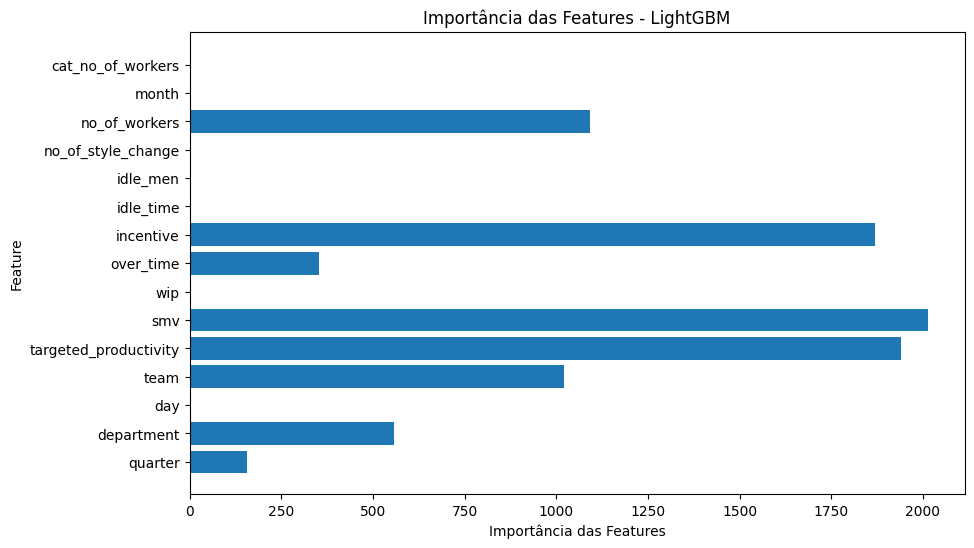

In [105]:
feature_selection = Modelo().feature_importance(50)

<div id='2'>
    <h1 id='imports'style="color:rosybrown ;text-align:center">Resultados</h1>
</div>    

Mean Absolute Error: 0.0988580251006865
Mean Squared Error: 0.018308963060139925
Root Mean Squared Error: 0.1353106169527725
R-squared: 31.05%
Mean Absolute Percentage Error: 15.80 %
Symmetric Mean Absolute Percentage Error: 14.29%


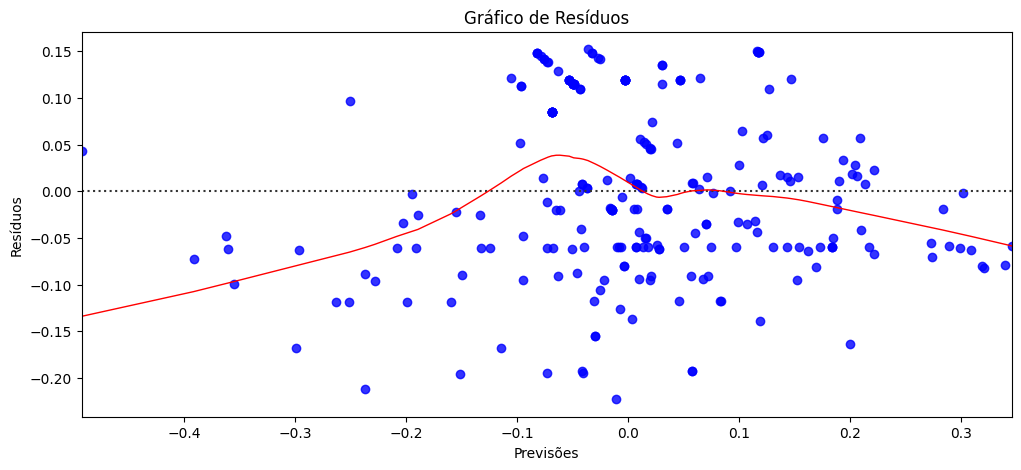

In [106]:
Modelo().model(feature_selection)